In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.signal import convolve2d
from scipy import fftpack

In [2]:
path_normal = "C:/Users/rezan/Arupreza/Gabor Assets/Normal/"
path_fuzz = "C:/Users/rezan/Arupreza/Gabor Assets/Fuzz/"
path_dos = "C:/Users/rezan/Arupreza/Gabor Assets/DoS/"
path_replay = "C:/Users/rezan/Arupreza/Gabor Assets/Replay/"
gabor_out = "C:/Users/rezan/Arupreza/Gabor Paper/Lisa/Gabor_Data/"
lisa_v2 = "C:/Users/rezan/Arupreza/Gabor Assets/Lisa New/"

In [4]:
Tesla_DoS = pd.read_csv(path_dos + "Tesla_DoS.csv")
Tesla_DoS_3 = pd.read_csv(path_dos + "Tesla_DoS_2.csv")

In [8]:
#DoS.to_csv(path_replay + 'Tesla_Replay_Full.csv', index=False)

In [9]:
def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(
        abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta))
    )
    xmax = np.ceil(max(1, xmax))
    ymax = max(
        abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta))
    )
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(
        -0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)
    ) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

# Apply the Gabor filter with sigma=1, theta=0, frequency=1
#result = gabor_transform(data, 0, 1, 1)

In [10]:
def gabor_transform(data, theta=0, sigma=1, frequency=1):
    """Apply Gabor filter to 2D data"""
    
    # Construct the Gabor filter
    gb = gabor(sigma, theta, 1/frequency, 0, 1)

    # Apply the filter to the data
    filtered = convolve2d(data, gb, mode='same')
    
    # Compute the Fourier transform of the filtered data
    fft = fftpack.fft2(filtered)
    
    # Return the magnitude of the Fourier transform
    return np.abs(fft)

In [11]:
def segmentation_fixed_len(df, window_size=100, overlap_ratio=1):
    #Select the feature and Initialize Parameters
    df = df[["CAN_ID", "Time_Gap"]]
    encoder = LabelEncoder()
    scaler = MinMaxScaler()
    
    timestamp = 0
    length = len(df)
    output = []
    #For Loop 
    for i in range(timestamp, length, int(window_size * (1 - overlap_ratio))):
        if i >= length - window_size:
            break
        else:
            df_out = df[i:i+window_size]
            df_out["Scaled_CAN_ID"] = encoder.fit_transform(df_out[["CAN_ID"]])
            df_out["Scaled_CAN_ID"] = scaler.fit_transform(df_out[['Scaled_CAN_ID']])
            df_out = df_out[["Scaled_CAN_ID", "Time_Gap"]]
            output.append(df_out)
        
    return output

In [12]:
def apply_gabor_filter_to_csv(csv_file, label, window_size=100, overlap_ratio=1, theta=0, sigma=1, frequency=1):
    """
    Apply segmentation and Gabor filter to a CSV file.
    """
    df = pd.read_csv(csv_file)
    segmented_df = segmentation_fixed_len(df, window_size, overlap_ratio)
    scaler = MinMaxScaler()
    gabor_filter_out = []
    for i in segmented_df:
        gabor_out = gabor_transform(i.values, theta, sigma, frequency)
        gabor_out = scaler.fit_transform(gabor_out)
        gabor_filter_out.append(gabor_out)
    gabor_filter_out = np.array(gabor_filter_out)
    gabor_filter_out = gabor_filter_out.reshape(-1, gabor_filter_out.shape[-1])
    new_df = pd.DataFrame(gabor_filter_out, columns=['Feature_1', 'Feature_2'])
    new_df["Label"] = np.repeat(label, len(new_df))
    return segmented_df, new_df

In [ ]:
x, y = apply_gabor_filter_to_csv(path_normal + "Kia_Normal.csv", "0", window_size=100, 
                                       overlap_ratio=0.5, theta=0, sigma=1, frequency=1)

In [40]:
#y.to_csv(gabor_out + 'Tesla_Normal_G1.csv', index=False)

# Visualization

In [258]:
Kia_Normal_G = pd.read_csv(gabor_out + "Kia_Normal_G.csv")[0:100000].reset_index()
Kia_Fuzzing_G = pd.read_csv(gabor_out + "Kia_Fuzz_G.csv")[100000:200000].reset_index()
Kia_DoS_G = pd.read_csv(gabor_out + "Kia_DoS_G.csv")[100000:200000].reset_index()
Kia_Replay_G = pd.read_csv(gabor_out + "Kia_Replay_G.csv")[100000:200000].reset_index()

Kia_Normal_G = pd.read_csv(gabor_out + "Kia_Normal_G.csv")[100000:200000].reset_index()
Kia_Fuzz_V2_G = pd.read_csv(gabor_out + "Kia_Fuzz_V2_G.csv")[100000:200000].reset_index()
Kia_DoS_V2_G = pd.read_csv(gabor_out + "Kia_DoS_V2_G.csv")[100000:200000].reset_index()
Kia_Replay_V2_G = pd.read_csv(gabor_out + "Kia_Replay_V2_G.csv")[100000:200000].reset_index()

Kia_Korea_Normal_G = pd.read_csv(gabor_out + "Kia_Korea_Normal_G.csv")[100000:200000].reset_index()
Kia_Korea_Fuzz_G = pd.read_csv(gabor_out + "Kia_Korea_Fuzz_G.csv")[100000:200000].reset_index()
Kia_Korea_DoS_G = pd.read_csv(gabor_out + "Kia_Korea_DoS_G.csv").reset_index()
Kia_Korea_Replay_G = pd.read_csv(gabor_out + "Kia_Korea_Replay_G.csv")[100000:200000].reset_index()

In [259]:
Kia_Korea_DoS_G

,index,Feature_1,Feature_2,Label
0,0,1.000000,0.154487,2
1,1,0.022651,0.391190,2
2,2,0.063646,0.986752,2
3,3,0.105560,1.000000,2
4,4,0.025520,0.513650,2
...,...,...,...,...
94795,94795,0.055917,0.082723,2
94796,94796,0.051917,0.144902,2
94797,94797,0.072835,1.000000,2
94798,94798,0.019607,0.248783,2


In [210]:
def plot_imposed_features(data1, data2, title1, title2, xlabel='Sample', ylabel='Amplitude', figsize=(12, 4)):
    # Create subplots with one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    # Plot the first and second data in the first subplot
    axs[0].plot(data1['Feature_1'], color='blue', label='Attack Free')
    axs[0].plot(data2['Feature_1'], color='red', label='Attack')
    axs[0].set_xlabel(xlabel, fontweight="bold", fontsize=14, color='black')
    axs[0].set_ylabel(ylabel, fontweight="bold", fontsize=14, color='black')
    axs[0].set_title(title1, fontweight="bold", fontsize=15, color='black')
    axs[0].legend(fontsize=16, title_fontsize=15)

    # Plot the third and fourth data in the second subplot
    axs[1].plot(data1['Feature_2'], color='green', label='Attack Free')
    axs[1].plot(data2['Feature_2'], color='orange', label='Attack')
    axs[1].set_xlabel(xlabel, fontweight="bold", fontsize=14, color='black')
    axs[1].set_ylabel(ylabel, fontweight="bold", fontsize=14, color='black')
    axs[1].set_title(title2, fontweight="bold", fontsize=15, color='black')
    axs[1].legend(fontsize=16, title_fontsize=15)

    plt.tight_layout()  # Adjusts subplot parameters for better spacing
    plt.show()

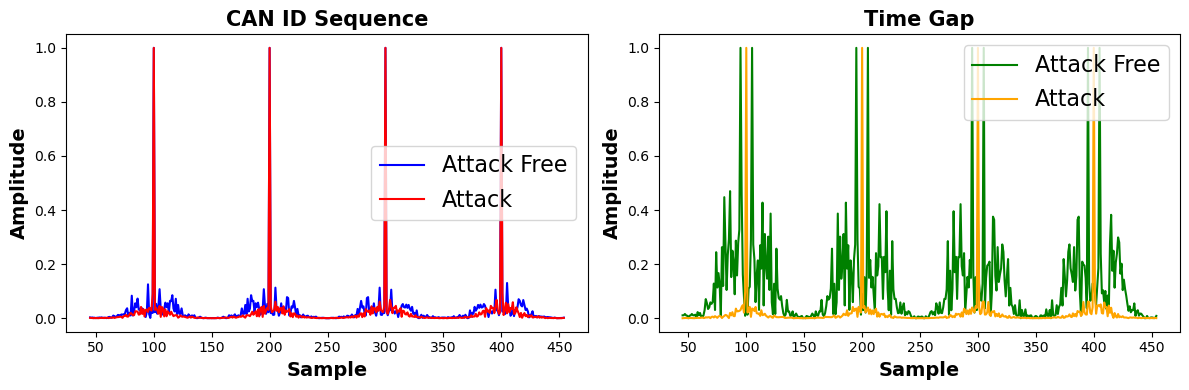

In [264]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Fuzzing_G[45:455], "CAN ID Sequence", "Time Gap")

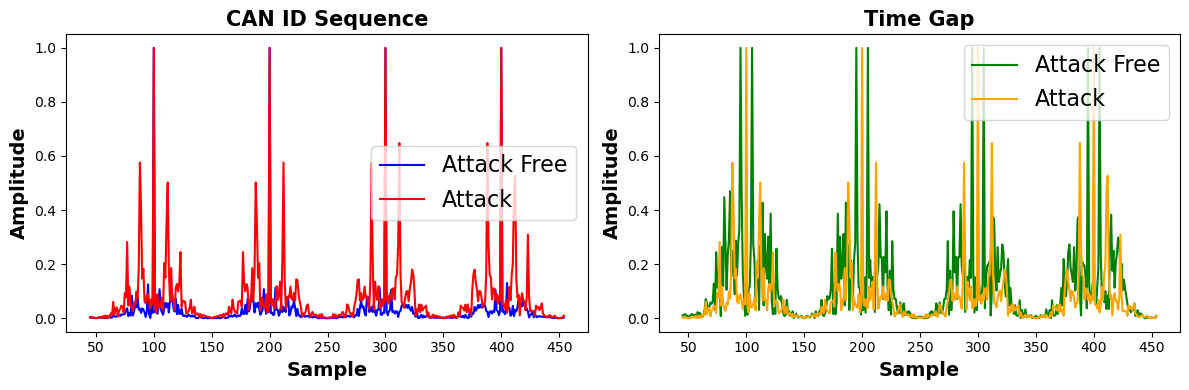

In [265]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_DoS_G[45:455], "CAN ID Sequence", "Time Gap")

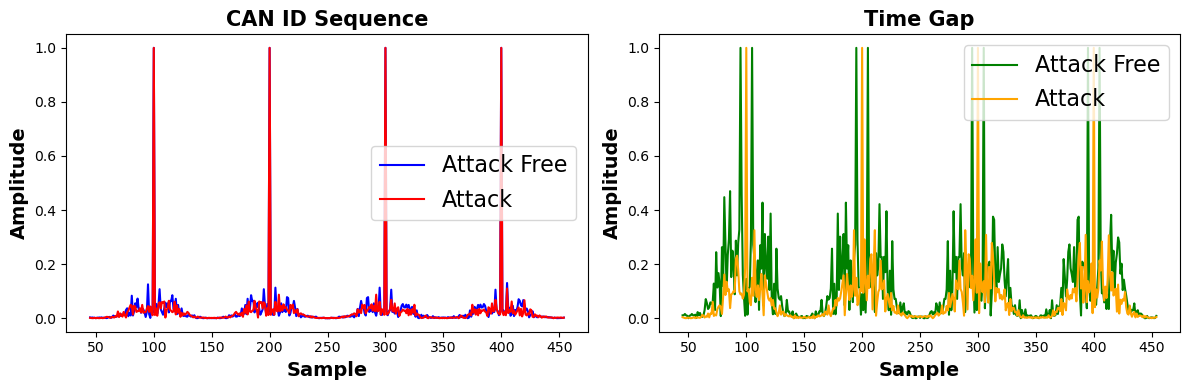

In [266]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Replay_G[45:455], "CAN ID Sequence", "Time Gap")

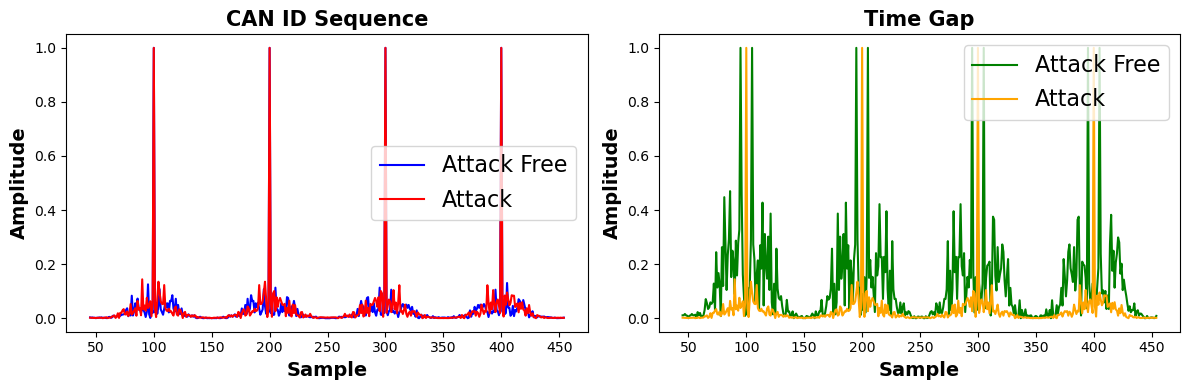

In [268]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Fuzz_V2_G[45:455], "CAN ID Sequence", "Time Gap")

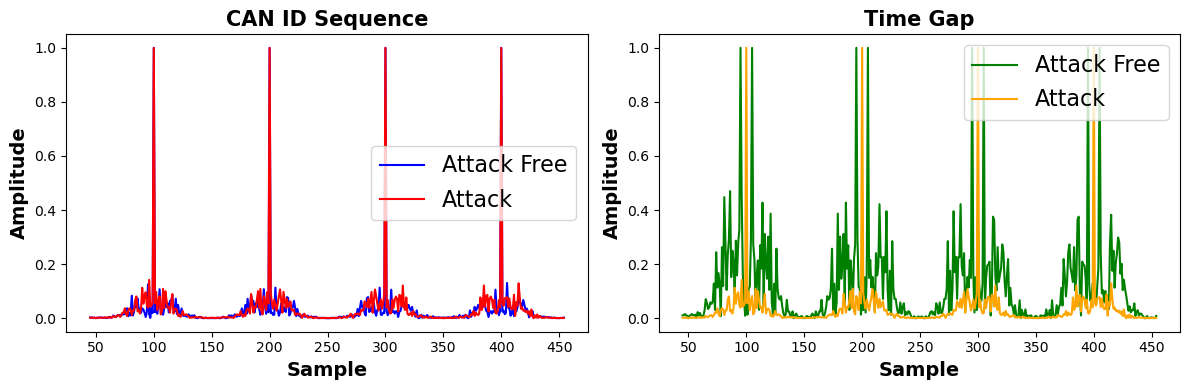

In [269]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_DoS_V2_G[45:455], "CAN ID Sequence", "Time Gap")

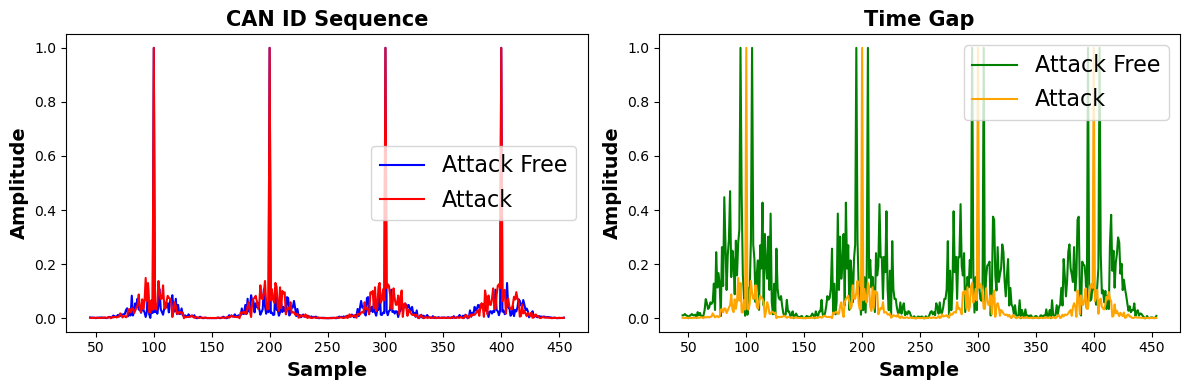

In [267]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Replay_V2_G[45:455], "CAN ID Sequence", "Time Gap")

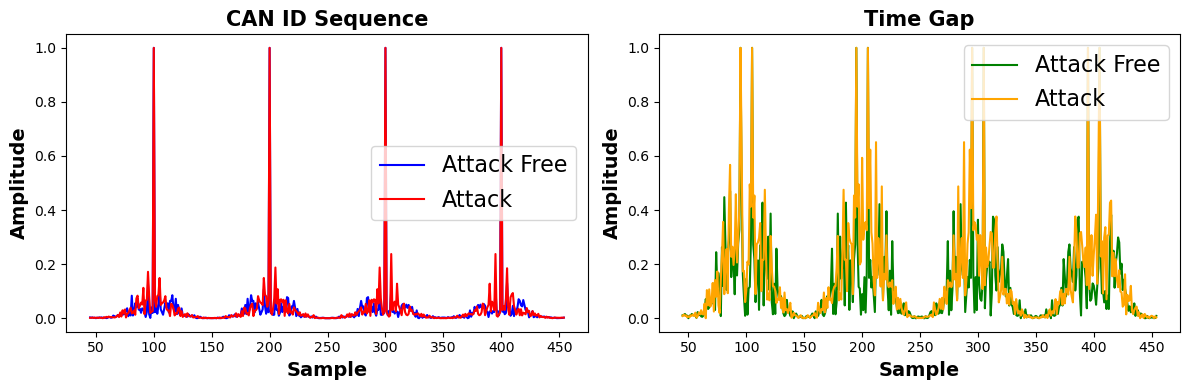

In [260]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Korea_Fuzz_G[45:455], "CAN ID Sequence", "Time Gap")

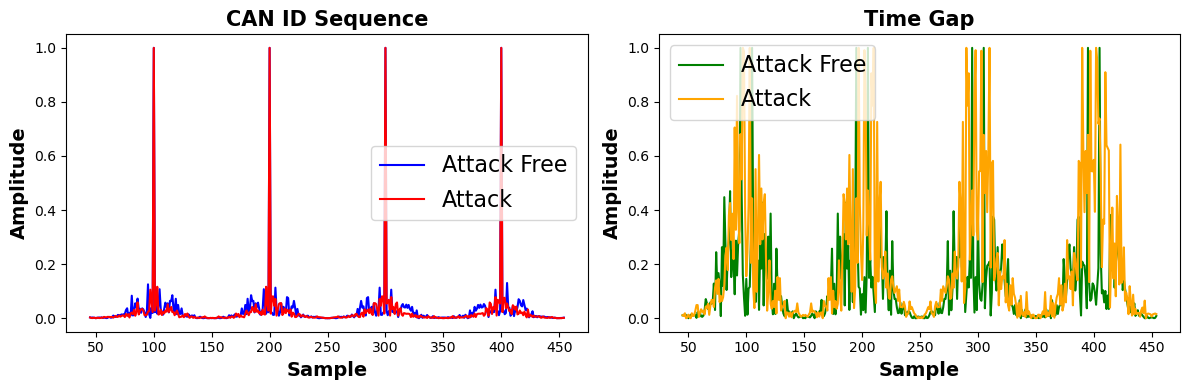

In [261]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Korea_DoS_G[45:455], "CAN ID Sequence", "Time Gap")

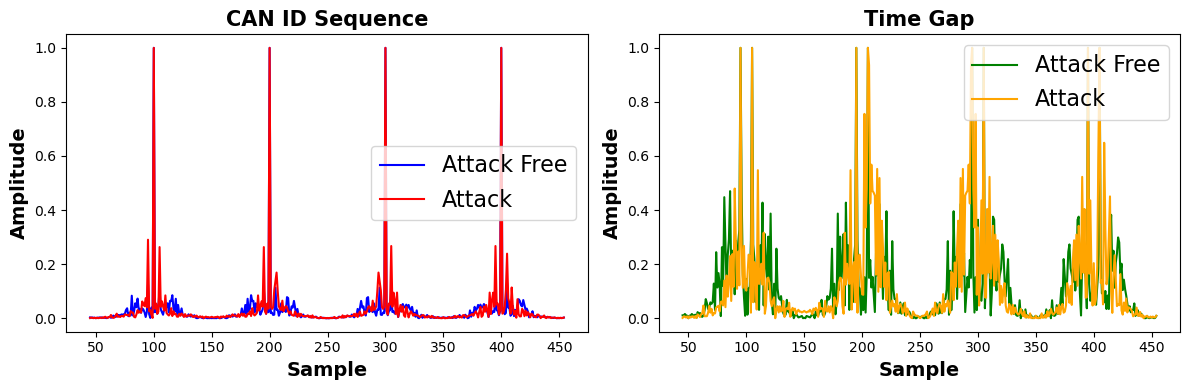

In [262]:
plot_imposed_features(Kia_Normal_G[45:455], Kia_Korea_Replay_G[45:455], "CAN ID Sequence", "Time Gap")